In [11]:
# Defaults

# System settings
systmpfs = '/tmp'
address = None
geotop_path = '../geotop/build/geotop'
variables_path = 'variables.csv'
output_dir = '.'

# Optimizer settings
num_workers = 2
budget = 8
algorithm = 'OnePlusOne'
timeout = 120
monitor_interval = 10
scale = 'D'
startdate = '01/01/2011 00:00'
targets = ['soil_moisture_content_50', 'sensible_heat_flux_in_air']
weights = [1.0, 1.0]

In [2]:
from os.path import join as joinpath
from subprocess import CalledProcessError, TimeoutExpired
from tempfile import TemporaryDirectory, NamedTemporaryFile

import numpy as np
from numpy.random import uniform
import pandas as pd
import matplotlib.pyplot as plt

from dask.distributed import Client, performance_report
import nevergrad as ng
import hiplot as hip
from SALib.analyze import delta

from simulations.matsch_b2 import observations, GEOtopRun, inputs_path

/home/max/.local/share/virtualenvs/MHPC-project-WaUKRq_w/lib/python3.8/site-packages/geotopy/__init__.py:35: RuntimeWarning: Default GEOTop executable not found, check your installation
  warnings.warn("Default GEOTop executable not found, check your installation",


In [3]:
if address:
    client = Client(address)
else:
    client = Client()

In [4]:
class GEOtopRunLogVars(GEOtopRun):
 
    def preprocess(self, working_dir, *args, **kwargs):
        
        for key, value in kwargs.items():
            if variables.type[key] == 'log':
                kwargs[key] = 10 ** value
                
        super().preprocess(working_dir, *args, **kwargs)

In [5]:
model = GEOtopRunLogVars(inputs_path,
                         exe=geotop_path,
                         run_args={'check': True, 
                                   'capture_output': True, 
                                   'timeout': timeout})

variables = pd.read_csv(variables_path, index_col='name')
variables['synth'] = [uniform(low=var.lower, high=var.upper) for name, var in variables.iterrows()]

In [6]:
def loss_function(*args, sim=None, **kwargs):
    if sim is None:
        with TemporaryDirectory(dir=systmpfs) as tmpdir:
            try:
                sim = model.eval(tmpdir, *args, **kwargs)
            except CalledProcessError:
                    return np.nan
            except TimeoutExpired:
                    return np.nan
    return sum(w * synth.metric(t, sim) for w, t in zip(weights, targets)) / sum(weights)

In [7]:
with TemporaryDirectory(dir=systmpfs) as tmpdir:
    synth = model.eval(tmpdir, **variables.synth.to_dict())

synth = observations(synth, scale=scale, start=startdate)

Before optimization loss is 0.6147843244367124


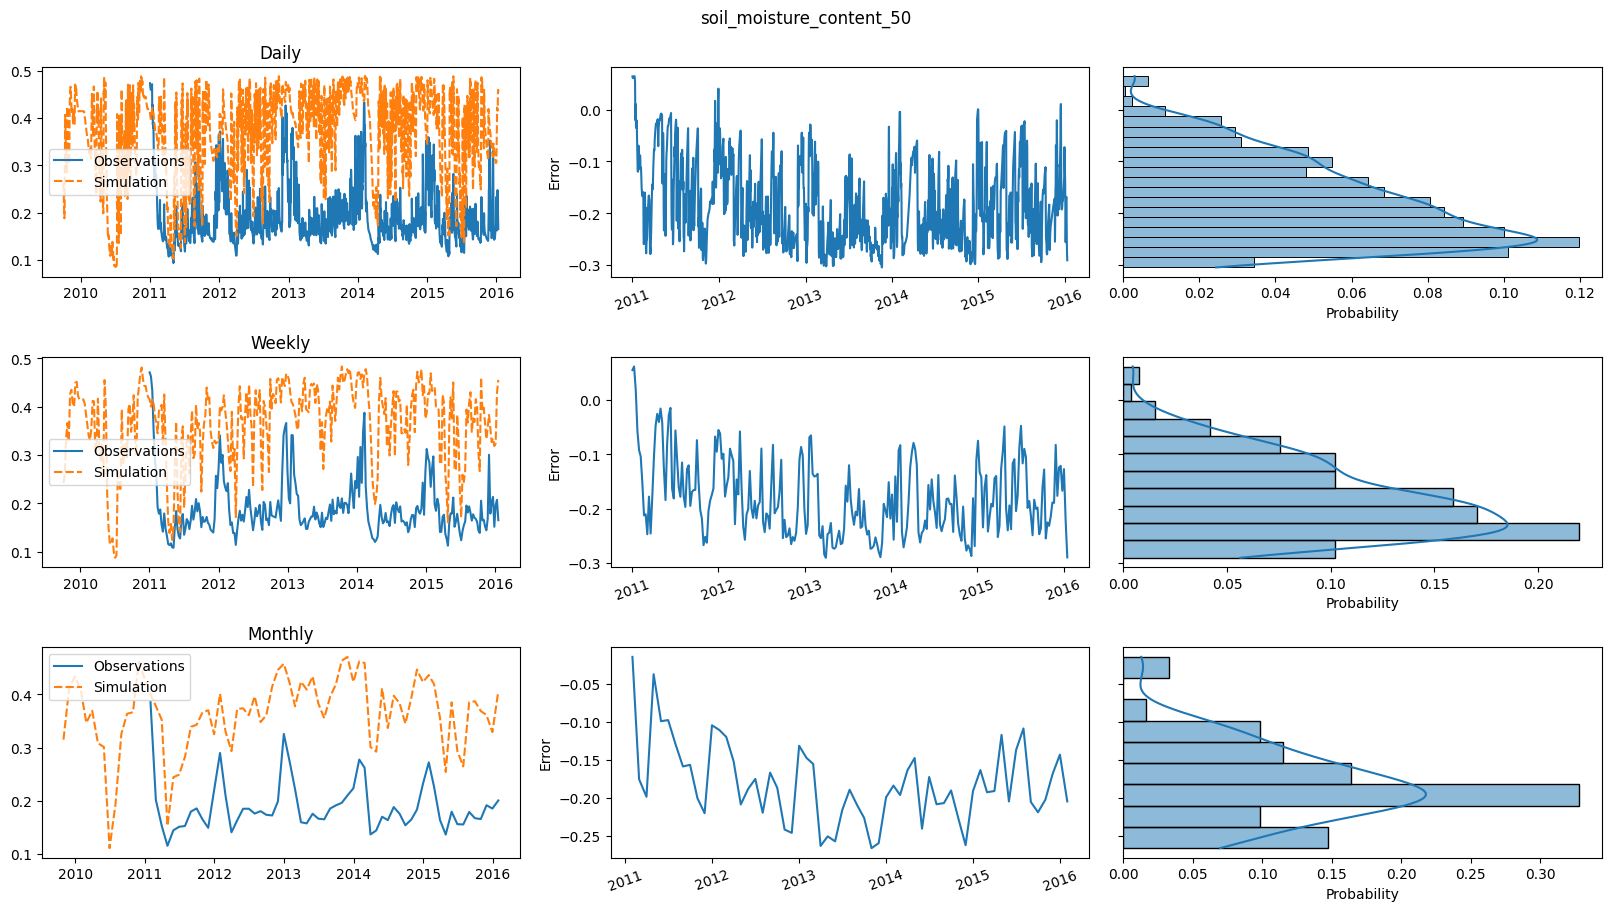

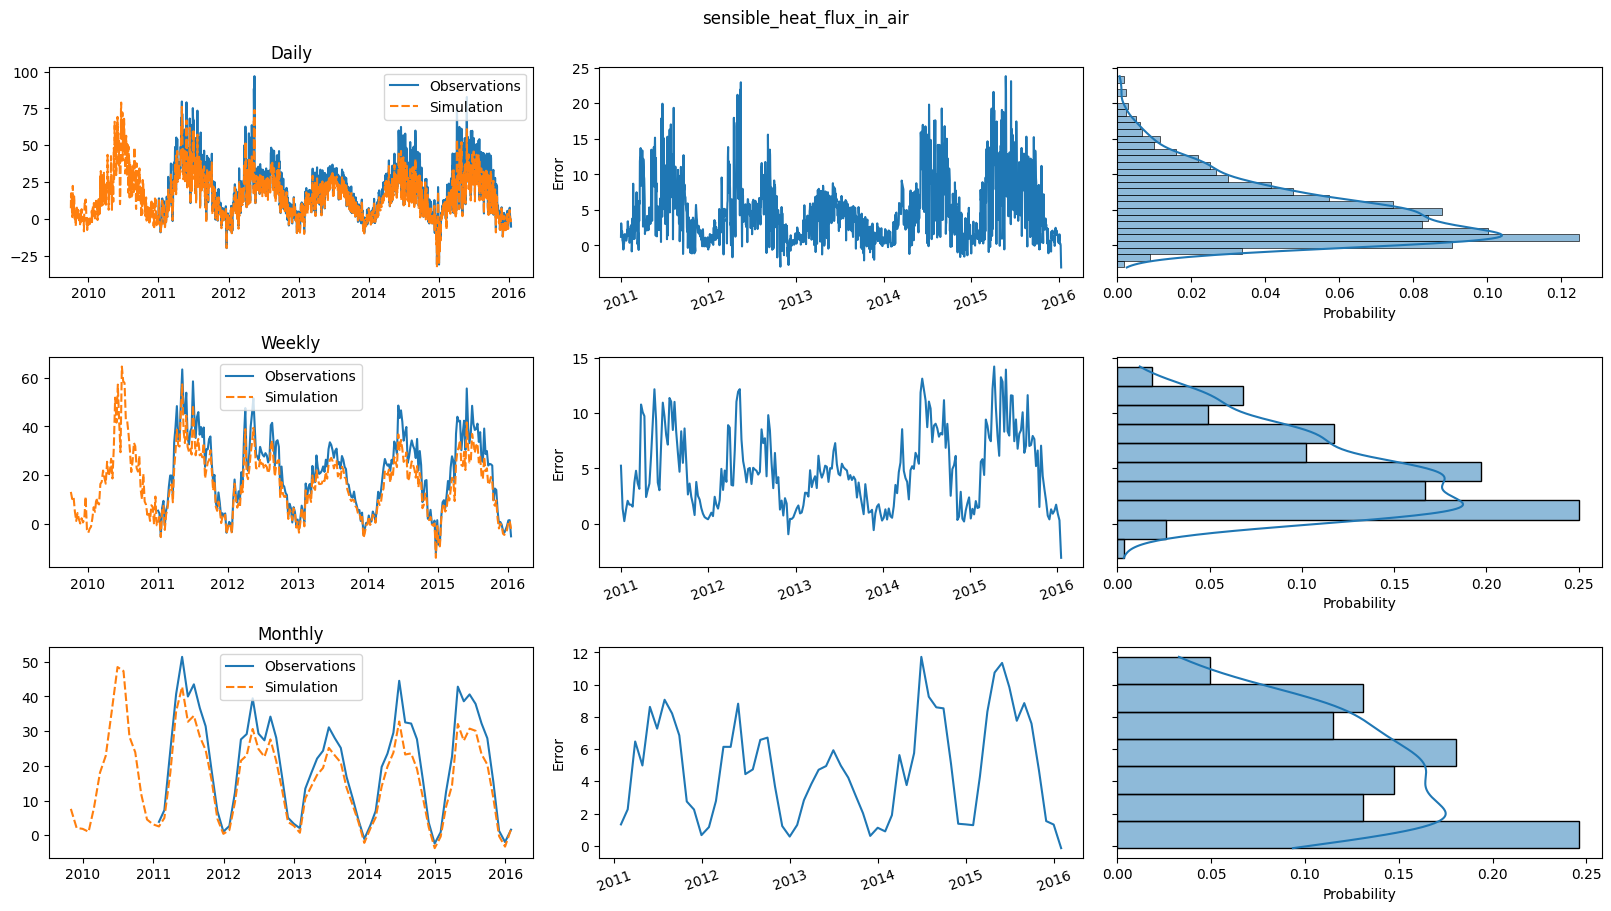

In [8]:
with TemporaryDirectory(dir=systmpfs) as tmpdir:
    sim = model.eval(tmpdir)
    print(f"Before optimization loss is {loss_function(sim=sim)}")
    for t in targets:
        synth.compare(t, sim, desc=t)
        plt.show()

In [9]:
kwargs = {name: ng.p.Scalar(init=value.suggested, lower=value.lower, upper=value.upper) 
          for name, value in variables.iterrows()}

optimizer = ng.optimizers.registry[algorithm](parametrization=ng.p.Instrumentation(**kwargs),
                                              budget=budget,
                                              num_workers=num_workers)

logfile = NamedTemporaryFile(dir=systmpfs)
logger = ng.callbacks.ParametersLogger(logfile.name)
optimizer.register_callback("tell",  logger)

In [12]:
with performance_report(filename=joinpath(output_dir, 'performance_report.html')):
    recommendation = optimizer.minimize(loss_function, executor=client, batch_mode=False)

In [13]:
samples = pd.DataFrame(logger.load())

samples.dropna(subset=['#loss'], inplace=True)
points = samples[variables.index].to_numpy()
losses = samples['#loss'].to_numpy()

problem = {'num_vars': variables.shape[0],
           'names': variables.index,
           'bounds': list(zip(variables.lower, variables.upper))}

SA = delta.analyze(problem, points, losses)

In [14]:
variables['best'] = pd.Series(recommendation.kwargs)
variables['err'] = 3 * (variables.synth - variables.best).abs() / (variables.upper - variables.lower)

pd.concat([variables, SA.to_df()], axis=1).sort_values('S1', ascending=False)

,suggested,lower,upper,type,synth,best,err,delta,delta_conf,S1,S1_conf
name,,,,,,,,,,,
VegReflNIR,0.20000,0.05000,0.40000,scalar,0.171100,0.380346,1.793532,0.269304,0.219850,0.560151,0.426710
NormalHydrConductivity,-2.00000,-4.30103,0.00000,log,-1.356177,-1.804083,0.312418,0.261273,0.197115,0.539703,0.475087
DecayCoeffCanopy,50.00000,0.00000,75.00000,scalar,45.409964,2.796788,1.704527,0.260864,0.217281,0.539703,0.498151
SoilAlbNIRDry,0.30000,0.05000,0.40000,scalar,0.153587,0.380424,1.944318,0.258526,0.206664,0.514540,0.450723
NVanGenuchten,1.50000,1.15000,2.00000,scalar,1.791458,1.521609,0.952408,0.014791,0.235447,0.277675,0.413572
SoilAlbVisDry,0.15000,0.05000,0.30000,scalar,0.193298,0.075256,1.416495,-0.021298,0.207566,0.246933,0.429697
CanopyFraction,0.60000,0.00000,1.00000,scalar,0.575535,0.087172,1.465091,0.013176,0.199856,0.245848,0.403375
MinStomatalRes,50.00000,10.00000,100.00000,scalar,13.845542,55.155256,1.376990,0.000065,0.206999,0.245848,0.440844
SoilAlbNIRWet,0.25000,0.05000,0.50000,scalar,0.238637,0.064639,1.159986,-0.012654,0.215991,0.104242,0.450029


In [15]:
experiment = logger.to_hiplot_experiment()

In [16]:
hidden_columns = ['uid', 
                  'from_uid', 
                  '#parametrization', 
                  '#optimizer', 
                  '#optimizer#noise_handling', 
                  '#optimizer#mutation',
                  '#optimizer#crossover',
                  '#optimizer#initialization',
                  '#optimizer#scale',
                  '#optimizer#recommendation',
                  '#optimizer#F1',
                  '#optimizer#F2',
                  '#optimizer#popsize',
                  '#optimizer#propagate_heritage',
                  '#session', 
                  '#lineage',
                  '#meta-sigma']

for name in variables.index:
    hidden_columns.append(name + '#sigma')
    hidden_columns.append(name + '#sigma#sigma')
    
table = experiment.display_data(hip.Displays.TABLE)
table.update({'hide': hidden_columns,
              'order_by': [['#num-tell', 'asc']]})

plot = experiment.display_data(hip.Displays.PARALLEL_PLOT)
plot.update({'hide': [*hidden_columns, '#num-tell'],
             'order': ['#generation', *variables.index, '#loss']})

In [21]:
experiment.to_html(joinpath(output_dir, 'optimization_report.html'));

After optimization loss is 0.21880556001552004


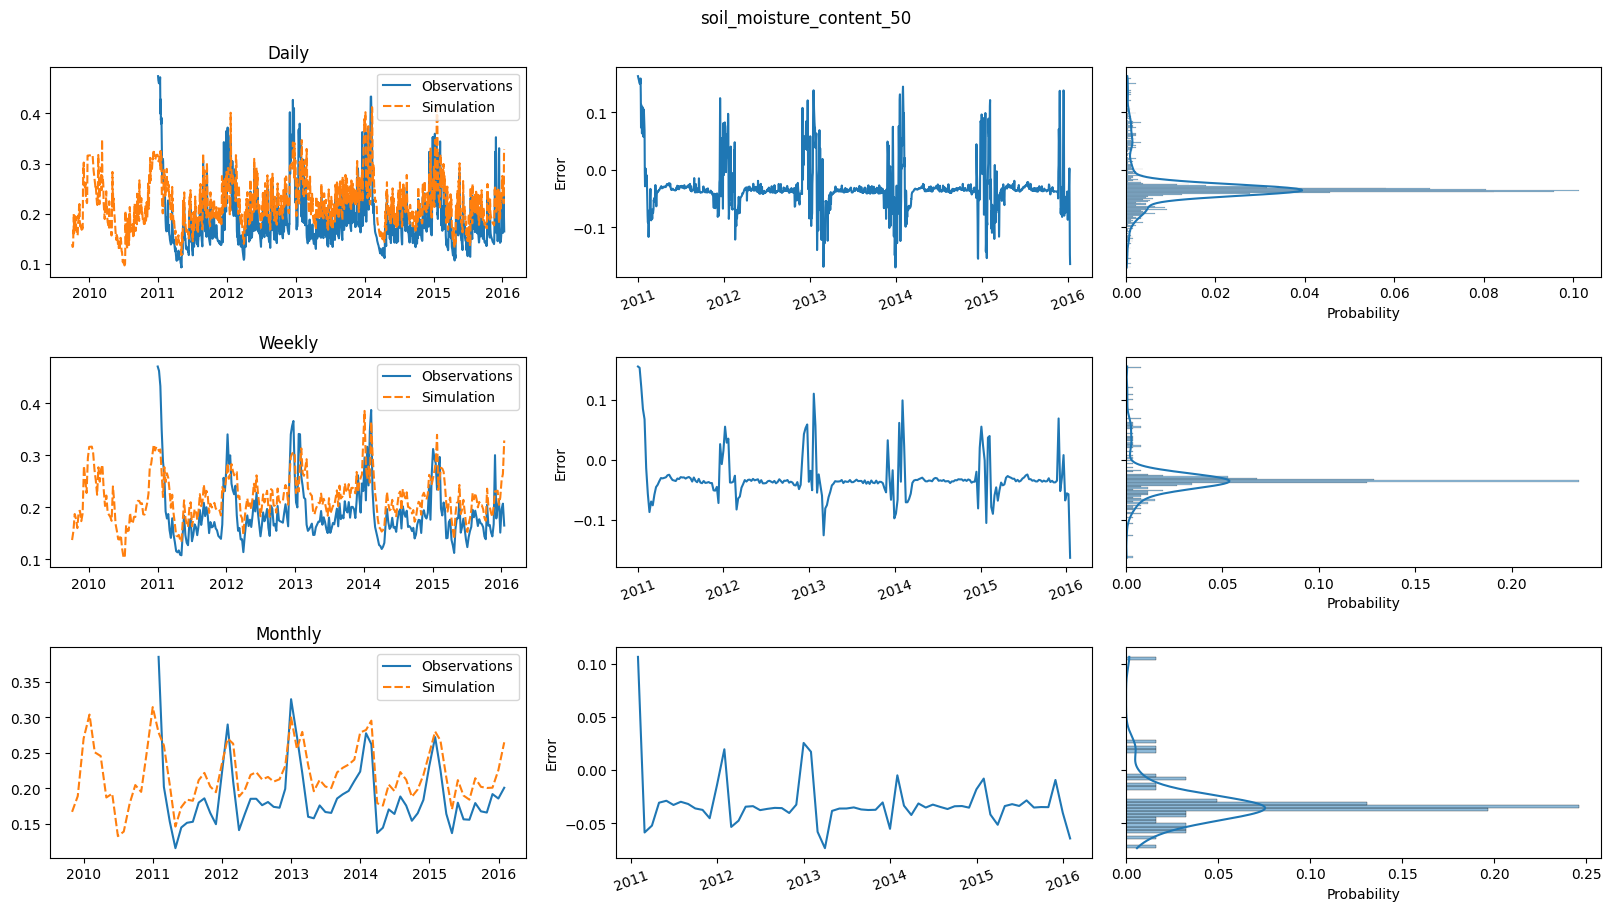

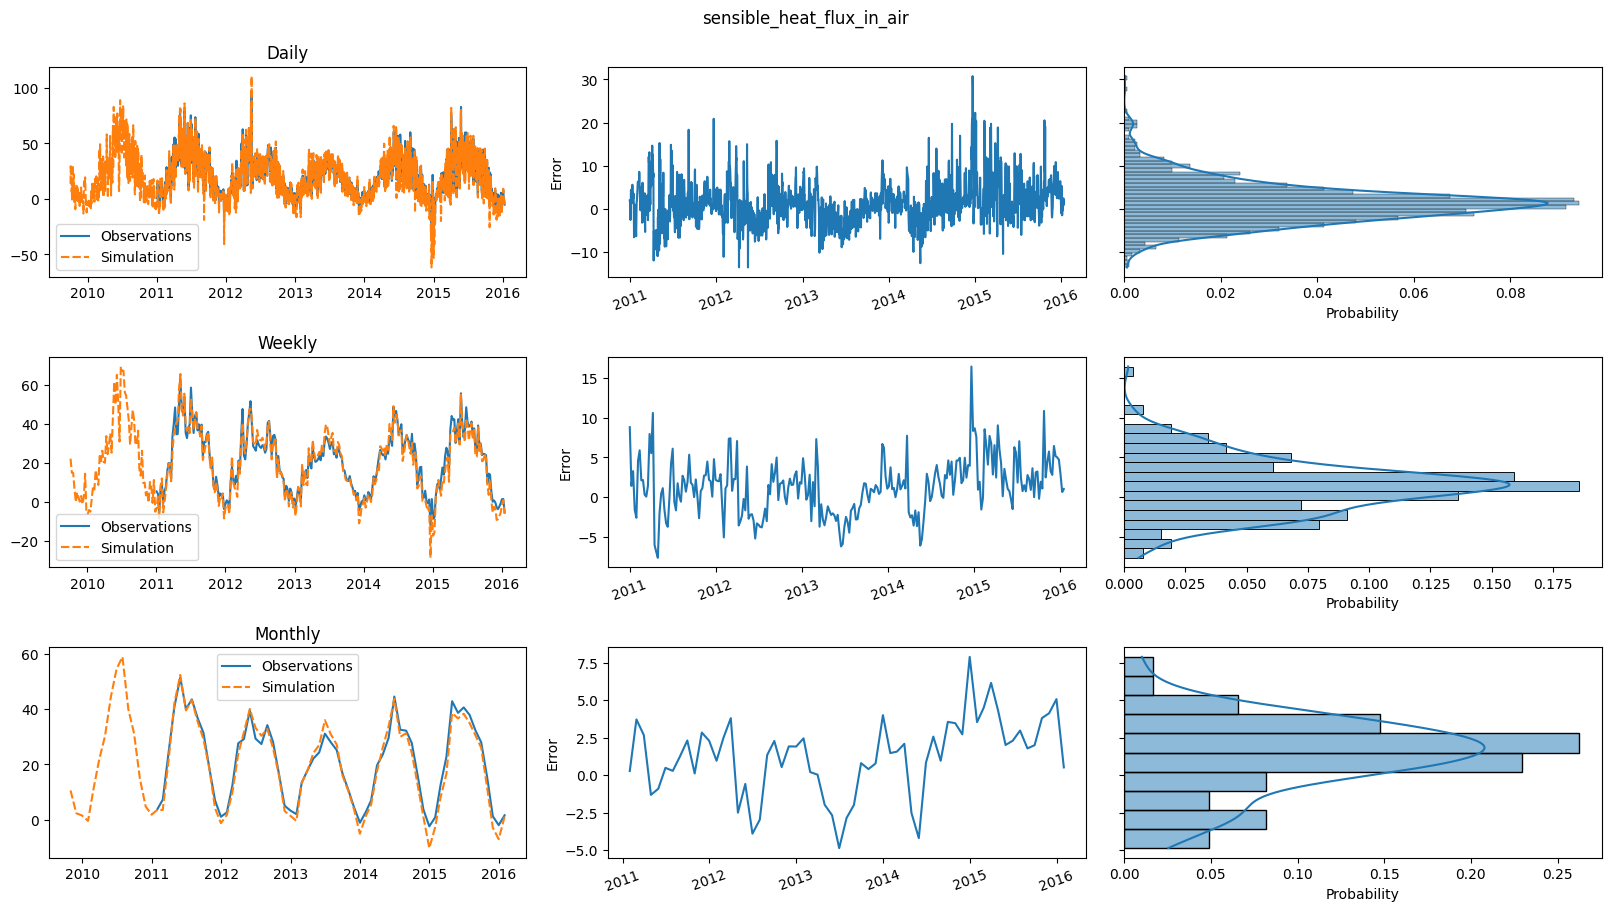

In [18]:
with TemporaryDirectory() as tmpdir:
    print(f"After optimization loss is {recommendation.loss}")
    sim = model.eval(tmpdir, **recommendation.kwargs)
    for t in targets:
        synth.compare(t, sim, desc=t)
        plt.show()